In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% ! important; }<style>"))

In [2]:

import numpy as np
from astropy.io import fits
import matplotlib.pylab as plt
import os

import matplotlib
%matplotlib notebook


from matplotlib import rcParams
import matplotlib as mpl

from matplotlib.ticker import MultipleLocator, FixedLocator
from matplotlib.gridspec import GridSpec

from astropy import units,constants

from astropy.table import Column
from astropy.time import Time

from scipy.interpolate import interp1d
from astropy.table import Table, Column


from scipy.signal import savgol_filter

from scipy.integrate import trapz
import pysynphot as S

from kapteyn import kmpfit

In [11]:
def spectrum_extinction_effect(wave, flux, EBV, extmodel='gal3', compare_display=False):
    ''' 
    apply or remove the effects of interstellar reddening on a source spectrum using Extinction provided bypysynphot. 

    INPUTS:
            wave: spectrum wavelength
            flux: spectrum flux
            EBV: extinction is defined R(V) = A(V)/E(B-V); negative value effectively dereddens the spectrum
            extmodel: extinction model, see here for details http://pysynphot.readthedocs.io/en/latest/spectrum.html

    '''
    sp = S.ArraySpectrum(wave=wave, flux=flux,
                         waveunits='angstrom', fluxunits='flam', keepneg=True)
    sp_deext = sp*S.Extinction(EBV, extmodel)

    wave_out = sp_deext.wave
    flux_out = sp_deext.flux

    if compare_display:
        plt.plot(sp.wave, sp.flux)
        plt.plot(sp_deext.wave, sp_deext.flux)
        plt.show()

    mask = np.logical_and(wave_out >= np.min(wave), wave_out <= np.max(wave))

    return wave_out[mask], flux_out[mask]

## load spectra


#### 2022jli

In [6]:
import pickle

outfile = '../data/spectra/2022jli.20230301.p' #load the spectra
with open(outfile, 'rb') as fp:
    specs_22jli = pickle.load(fp)

spectable = specs_22jli['spectable']
spectable.sort('phase')


t0_22jli = 2459704.67 # discovery time 2022-05-05T04:04:48.00 by Libert Monard see https://www.wis-tns.org/object/2022jli
z_22jli = 0.0055

In [13]:
EBV_host = 0.25
EBV_mw = 0.039
EBV = EBV_host + EBV_mw#total EBV, MW+host 

#### iPTF15dtg

In [7]:
t0_15dtg = 2457333.448 #Taddia et al 2016 we adopt the average between the epochs of last non-detection and discovery as the explosion date (texplo = JD 2 457 333.448   0.483),
 
z_15dtg = 0.0524


iptf15dtg_dir = '../data/comparison_sne/iPTF15dtg/'
spectable_15dtg_wiserep = Table.read('../data/comparison_sne/iPTF15dtg/wiserep_spectra.csv', format='ascii.csv')
#print(spectable_2013ge_wiserep.keys())

specinfo_15dtg = {}


phases = []
specnames = []
for jd, specfile in spectable_15dtg_wiserep[['JD', 'Ascii file']]:
    #print(jd, specfile)
    phase = jd- t0_15dtg
    phases.append(phase)
    specname = str(np.around(phase,1))+'d'
    specnames.append(specname)
    try:
        specdata = np.loadtxt(os.path.join(iptf15dtg_dir, specfile))
    except:
        specdata = np.loadtxt(os.path.join(iptf15dtg_dir, specfile), skiprows=1) 
    specinfo_15dtg[specname] = {}
    specinfo_15dtg[specname]['phase'] = phase
    specinfo_15dtg[specname]['spec'] = specdata
    
spectable_15dtg_wiserep.add_column(Column(phases, name='phase'))
spectable_15dtg_wiserep.add_column(Column(specnames, name='specname'))

print(len(spectable_15dtg_wiserep))

printtable = spectable_15dtg_wiserep[['specname', 'Ascii file','JD', 'phase']]
printtable.pprint_all()

16
specname                      Ascii file                            JD             phase       
-------- --------------------------------------------------- --------------- ------------------
    3.2d         iPTF15dtg_2457336.60_TNG_DOLORES_iPTF.ascii       2457336.6 3.1520000002346933
    4.5d          iPTF15dtg_2457337.98_Keck1_LRIS_iPTF.ascii      2457337.98  4.532000000122935
   17.0d         iPTF15dtg_2457350.46_TNG_DOLORES_iPTF.ascii      2457350.46 17.012000000104308
   25.4d      iPTF15dtg_2457358.85_DCT_Deveny-LMI_iPTF.ascii 2457358.8499884 25.401988400146365
   29.1d          iPTF15dtg_2457362.50_Keck1_LRIS_iPTF.ascii       2457362.5  29.05200000014156
   34.0d          iPTF15dtg_2457367.43_NOT_ALFOSC_iPTF.ascii      2457367.43   33.9820000003092
   64.9d         iPTF15dtg_2457398.32_TNG_DOLORES_iPTF.ascii      2457398.32  64.87199999997392
   82.9d          iPTF15dtg_2457416.37_NOT_ALFOSC_iPTF.ascii      2457416.37  82.92200000025332
   97.0d 41012_2016-02-11_22-04-48.00

#### 2013ge

In [16]:
TmaxB_13ge = 56615.7+2400000.5 #from table 7 of https://iopscience.iop.org/article/10.3847/0004-637X/821/1/57
 
z_13ge = 0.004356


sn2013ge_dir = '../data/comparison_sne/2013ge/'
spectable_13ge_wiserep = Table.read('../data/comparison_sne/2013ge/wiserep_spectra.csv', format='ascii.csv')

specinfo_13ge = {}


phases = []
specnames = []
for jd, specfile in spectable_13ge_wiserep[['JD', 'Ascii file']]:
    #print(jd, specfile)
    phase = jd- TmaxB_13ge
    phases.append(phase)
    specname = str(np.around(phase,1))+'d'
    specnames.append(specname)
    try:
        specdata = np.loadtxt(os.path.join(sn2013ge_dir, specfile))
    except:
        specdata = np.loadtxt(os.path.join(sn2013ge_dir, specfile), skiprows=1) 
    specinfo_13ge[specname] = {}
    specinfo_13ge[specname]['phase'] = phase
    specinfo_13ge[specname]['spec'] = specdata
    
spectable_13ge_wiserep.add_column(Column(phases, name='phase'))
spectable_13ge_wiserep.add_column(Column(specnames, name='specname'))

print(len(spectable_13ge_wiserep))

printtable = spectable_13ge_wiserep[['specname', 'Ascii file','JD', 'phase']]
printtable.pprint_all()

40
specname                         Ascii file                               JD              phase       
-------- --------------------------------------------------------- --------------- -------------------
  -10.7d          2013ge_2013-11-09_00-00-00_MMT_MMT-Blue_None.flm       2456605.5 -10.700000000186265
   -9.7d          2013ge_2013-11-10_00-00-00_MMT_MMT-Blue_None.flm       2456606.5  -9.700000000186265
   -9.7d        2013ge_2013-11-10_00-00-00_MMT_MMT-Blue_None_0.flm       2456606.5  -9.700000000186265
   -8.7d          2013ge_2013-11-11_00-00-00_MMT_MMT-Blue_None.flm       2456607.5  -8.700000000186265
    0.3d   2013ge_2013-11-20_00-00-00_Magellan-Baade_FIRE_None.flm       2456616.5  0.2999999998137355
    1.3d         2013ge_2013-11-21_00-00-00_MMT_Hectospec_None.flm       2456617.5  1.2999999998137355
    8.8d SN_2013ge_2013-11-28_11-25-26_Lick-3m_KAST_UCB-SNDB_0.flm 2456624.9759954   8.775995399802923
    9.3d         2013ge_2013-11-29_00-00-00_MMT_Hectospec_None.flm    

#### 2004gk

2014AJ....147...99M Optical Spectra of 73 Stripped-envelope Core-collapse Supernovae

In [19]:
t0_04gk = 2453335 #discovery date https://ui.adsabs.harvard.edu/abs/2004IAUC.8446....1Q/abstract
 
z_04gk = 0.000407

sn04gk_dir = '../data/comparison_sne/2004gk/'
spectable_04gk_wiserep = Table.read('../data/comparison_sne/2004gk/wiserep_spectra.csv', format='ascii.csv')
print(spectable_04gk_wiserep.keys())

specinfo_04gk = {}


phases = []
specnames = []
for jd, specfile in spectable_04gk_wiserep[['JD', 'Ascii file']]:
    #print(jd, specfile)
    phase = jd- t0_04gk
    phases.append(phase)
    specname = str(np.around(phase,1))+'d'
    specnames.append(specname)
    try:
        specdata = np.loadtxt(os.path.join(sn04gk_dir, specfile))
    except:
        specdata = np.loadtxt(os.path.join(sn04gk_dir, specfile), skiprows=1) 
    specinfo_04gk[specname] = {}
    specinfo_04gk[specname]['phase'] = phase
    specinfo_04gk[specname]['spec'] = specdata
    
spectable_04gk_wiserep.add_column(Column(phases, name='phase'))
spectable_04gk_wiserep.add_column(Column(specnames, name='specname'))

print(len(spectable_04gk_wiserep))

printtable = spectable_04gk_wiserep[['specname', 'Ascii file','JD', 'phase','Publish']]
printtable.pprint_all()

['Obj. ID', 'IAU name', 'Internal name/s', 'Obj. RA', 'Obj. DEC', 'Obj. Type', 'Redshift', 'Spec. ID', 'Obs-date', 'JD', 'From', 'Telescope', 'Instrument', 'Observer/s', 'Reducer/s', 'Source group', 'Public', 'Associated groups', 'End prop. period', 'Ascii file', 'Fits file', 'Spec. type', 'Spec. quality', 'Extinction-Corrected', 'WL Medium', 'WL Units', 'Flux Unit Coefficient', 'Spec. units', 'Flux Calibrated By', 'Exp-time', 'Aperture (slit)', 'HA', 'Airmass', 'Dichroic', 'Grism', 'Grating', 'Blaze', 'Lambda-min', 'Lambda-max', 'Del-Lambda', 'Contrib', 'Publish', 'Remarks', 'Created by', 'Creation date']
37
specname                          Ascii file                                 JD             phase              Publish      
-------- ------------------------------------------------------------ --------------- ------------------ -------------------
    8.0d SN2004gk_2004-12-03_13-12-00_FLWO-1.5m_FAST_CfA-Stripped.flm      2453343.05  8.049999999813735 2014AJ....147...99M
   14.0d

#### 2007gr

In [21]:

TmaxB_07gr = 2454337  #2007-08-24
t0_07gr = 2454325.5 #+/-2.5  from Hunter et al. 2009
 
z_07gr = 0.001728

print(TmaxB_07gr-t0_07gr)

sn2007gr_dir = '../data/comparison_sne/2007gr/wiserep_spectra/'
spectable_2007gr_wiserep = Table.read('../data/comparison_sne/2007gr/wiserep_spectra/wiserep_spectra.csv', format='ascii.csv')
#print(spectable_2007gr_wiserep.keys())

specinfo_2007gr = {}


phases = []
specnames = []
for jd, specfile in spectable_2007gr_wiserep[['JD', 'Ascii file']]:
    phase = jd- t0_07gr
    phases.append(phase)
    specname = str(np.around(phase,1))+'d'
    specnames.append(specname)
    specdata = np.loadtxt(os.path.join(sn2007gr_dir, specfile))
    specinfo_2007gr[specname] = {}
    specinfo_2007gr[specname]['phase'] = phase
    specinfo_2007gr[specname]['spec'] = specdata
    
spectable_2007gr_wiserep.add_column(Column(phases, name='phase'))
spectable_2007gr_wiserep.add_column(Column(specnames, name='specname'))

print(len(spectable_2007gr_wiserep))

printtable = spectable_2007gr_wiserep[['specname', 'Ascii file','JD', 'phase']]
printtable.pprint_all()

11.5
45
specname                          Ascii file                                 JD             phase       
-------- ------------------------------------------------------------ --------------- ------------------
    3.5d    SN_2007gr_2007-08-16_11-55-40_Lick-3m_KAST_UCB-SNDB_0.flm 2454328.9969907  3.496990699786693
    4.0d           2007gr_2007-08-17_00-00-00_Other_Other_SUSPECT.dat       2454329.5                4.0
    4.6d      SN_2007gr_2007-08-17_15-10-04_Keck1_LRIS_UCB-SNDB_0.flm 2454330.1319907  4.631990700028837
    5.0d           2007gr_2007-08-18_00-00-00_Other_Other_SUSPECT.dat       2454330.5                5.0
    7.0d           2007gr_2007-08-20_00-00-00_Other_Other_SUSPECT.dat       2454332.5                7.0
    8.0d           2007gr_2007-08-21_00-00-00_Other_Other_SUSPECT.dat       2454333.5                8.0
    8.5d    SN_2007gr_2007-08-21_12-15-50_Lick-3m_KAST_UCB-SNDB_0.flm 2454334.0109954    8.5109954001382
    9.0d           2007gr_2007-08-22_00-00-00_O

#### 1997dq

In [23]:
TmaxB_97dq = 50720.4+2400000.5 #
 
z_97dq = 0.003196


sn2097dq_dir = '../data/comparison_sne/1997dq/'
spectable_97dq_wiserep = Table.read('../data/comparison_sne/1997dq/wiserep_spectra.csv', format='ascii.csv')

specinfo_97dq = {}


phases = []
specnames = []
for jd, specfile in spectable_97dq_wiserep[['JD', 'Ascii file']]:
    #print(jd, specfile)
    phase = jd- TmaxB_97dq
    phases.append(phase)
    specname = str(np.around(phase,1))+'d'
    specnames.append(specname)
    try:
        specdata = np.loadtxt(os.path.join(sn2097dq_dir, specfile))
    except:
        specdata = np.loadtxt(os.path.join(sn2097dq_dir, specfile), skiprows=1) 
    specinfo_97dq[specname] = {}
    specinfo_97dq[specname]['phase'] = phase
    specinfo_97dq[specname]['spec'] = specdata
    
spectable_97dq_wiserep.add_column(Column(phases, name='phase'))
spectable_97dq_wiserep.add_column(Column(specnames, name='specname'))

print(len(spectable_97dq_wiserep))

printtable = spectable_97dq_wiserep[['specname', 'Ascii file','JD', 'phase']]
printtable.pprint_all()

20
specname                          Ascii file                                 JD             phase       
-------- ------------------------------------------------------------ --------------- ------------------
   39.1d SN1997dq_1997-11-07_12-57-36_FLWO-1.5m_FAST_CfA-Stripped.flm      2450760.04 39.140000000130385
   39.6d          1997dq_1997-11-08_00-00-00_Lick-3m_KAST_SUSPECT.dat       2450760.5  39.60000000009313
   39.6d      SN_1997dq_1997-11-08_00-00-00_Lick-3m_KAST_UCB-SNDB.flm       2450760.5  39.60000000009313
   40.2d       SN1997dq_1997-11-08_13-30-43_Lick-3m_KAST_UCB-SNDB.flm 2450761.0629977  40.16299770027399
   54.1d SN1997dq_1997-11-22_12-57-36_FLWO-1.5m_FAST_CfA-Stripped.flm      2450775.04 54.140000000130385
   57.1d SN1997dq_1997-11-25_12-57-36_FLWO-1.5m_FAST_CfA-Stripped.flm      2450778.04 57.140000000130385
   61.1d SN1997dq_1997-11-29_12-57-36_FLWO-1.5m_FAST_CfA-Stripped.flm      2450782.04 61.140000000130385
   66.1d SN1997dq_1997-12-04_12-00-00_FLWO-1.5m_FAST

#### 2012au

In [25]:
TmaxB_12au = 56006.4+2400000.5 #from https://ui.adsabs.harvard.edu/abs/2021MNRAS.507.1229P/abstract
 
z_12au = 0.004483


sn2012au_dir = '../data/comparison_sne/2012au/'
spectable_12au_wiserep = Table.read('../data/comparison_sne/2012au/wiserep_spectra.csv', format='ascii.csv')

specinfo_12au = {}


phases = []
specnames = []
for jd, specfile in spectable_12au_wiserep[['JD', 'Ascii file']]:
    #print(jd, specfile)
    phase = jd- TmaxB_12au
    phases.append(phase)
    specname = str(np.around(phase,1))+'d'
    specnames.append(specname)
    try:
        specdata = np.loadtxt(os.path.join(sn2012au_dir, specfile))
    except:
        specdata = np.loadtxt(os.path.join(sn2012au_dir, specfile), skiprows=1) 
    specinfo_12au[specname] = {}
    specinfo_12au[specname]['phase'] = phase
    specinfo_12au[specname]['spec'] = specdata
    
spectable_12au_wiserep.add_column(Column(phases, name='phase'))
spectable_12au_wiserep.add_column(Column(specnames, name='specname'))

print(len(spectable_12au_wiserep))

printtable = spectable_12au_wiserep[['specname', 'Ascii file','JD', 'phase']]
printtable.pprint_all()

10
specname                         Ascii file                               JD              phase       
-------- --------------------------------------------------------- --------------- -------------------
   -4.9d   SN_2012au_2012-03-15_12-23-02_Keck1_LRIS_UCB-SNDB_0.flm 2456002.0159954  -4.884004599880427
   -3.4d      SN2012au_2012-03-17_00-00-00_FLWO-1.5m_FAST_None.flm       2456003.5 -3.3999999999068677
    6.6d        SN2012au_2012-03-27_00-00-00_MMT_MMT-Blue_None.flm       2456013.5   6.600000000093132
   31.6d SN2012au_2012-04-21_00-00-00_Magellan-Baade_FIRE_None.txt       2456038.5  31.600000000093132
   57.6d      SN2012au_2012-05-17_00-00-00_FLWO-1.5m_FAST_None.flm       2456064.5   57.60000000009313
   83.6d SN2012au_2012-06-12_00-00-00_Magellan-Baade_FIRE_None.txt       2456090.5   83.60000000009313
   88.0d   SN_2012au_2012-06-16_08-34-04_Keck1_LRIS_UCB-SNDB_0.flm 2456094.8569907    87.9569907002151
  273.6d        SN2012au_2012-12-19_00-00-00_MMT_MMT-Blue_None.flm    

#### 2015bn

In [27]:
TmaxB_15bn = 2457102.5 #
 
z_15bn = 0.1136


sn2015bn_dir = '../data/comparison_sne/2015bn/'
spectable_15bn_wiserep = Table.read('../data/comparison_sne/2015bn/wiserep_spectra.csv', format='ascii.csv')

specinfo_15bn = {}


phases = []
specnames = []
for jd, specfile in spectable_15bn_wiserep[['JD', 'Ascii file']]:
    #print(jd, specfile)
    phase = jd- TmaxB_15bn
    phases.append(phase)
    specname = str(np.around(phase,1))+'d'
    specnames.append(specname)
    try:
        specdata = np.loadtxt(os.path.join(sn2015bn_dir, specfile))
    except:
        specdata = np.loadtxt(os.path.join(sn2015bn_dir, specfile), skiprows=1) 
    specinfo_15bn[specname] = {}
    specinfo_15bn[specname]['phase'] = phase
    specinfo_15bn[specname]['spec'] = specdata
    
spectable_15bn_wiserep.add_column(Column(phases, name='phase'))
spectable_15bn_wiserep.add_column(Column(specnames, name='specname'))

print(len(spectable_15bn_wiserep))

printtable = spectable_15bn_wiserep[['specname', 'Ascii file','JD', 'phase']]
printtable.pprint_all()

37
specname                         Ascii file                               JD             phase       
-------- --------------------------------------------------------- --------------- ------------------
  -32.0d    2015bn_2015-02-17_00-00-00_ESO-NTT_EFOSC2-NTT_None.txt       2457070.5              -32.0
  -31.0d  2015bn_2015-02-18_00-00-00_Magellan-Baade_IMACS_None.txt       2457071.5              -31.0
  -30.5d   2015bn_2015-02-18_12-00-00_ESO-NTT_EFOSC2-NTT_None.asci       2457072.0              -30.5
  -25.0d        2015bn_2015-02-24_00-00-00_ANU-2.3m_WiFeS_None.txt       2457077.5              -25.0
  -25.0d          2015bn_2015-02-24_00-00-00_ESO-NTT_Sofi_None.txt       2457077.5              -25.0
  -24.0d    2015bn_2015-02-25_00-00-00_ESO-NTT_EFOSC2-NTT_None.txt       2457078.5              -24.0
  -20.0d              2015bn_2015-03-01_00-00-00_LT_SPRAT_None.txt       2457082.5              -20.0
  -10.0d          2015bn_2015-03-11_00-00-00_MMT_MMT-Blue_None.txt       245709

#### 2007bi

In [55]:
TmaxB_07bi = 2454566.5-412 #
 
z_07bi = 0.1279


sn2007bi_dir = '../data/comparison_sne/2007bi/'
spectable_07bi_wiserep = Table.read('../data/comparison_sne/2007bi/wiserep_spectra.csv', format='ascii.csv')

specinfo_07bi = {}


phases = []
specnames = []
for jd, specfile in spectable_07bi_wiserep[['JD', 'Ascii file']]:
    #print(jd, specfile)
    phase = jd- TmaxB_07bi
    phases.append(phase)
    specname = str(np.around(phase,1))+'d'
    specnames.append(specname)
    try:
        specdata = np.loadtxt(os.path.join(sn2007bi_dir, specfile))
    except:
        specdata = np.loadtxt(os.path.join(sn2007bi_dir, specfile), skiprows=1) 
    specinfo_07bi[specname] = {}
    specinfo_07bi[specname]['phase'] = phase
    specinfo_07bi[specname]['spec'] = specdata
    
spectable_07bi_wiserep.add_column(Column(phases, name='phase'))
spectable_07bi_wiserep.add_column(Column(specnames, name='specname'))

print(len(spectable_07bi_wiserep))

printtable = spectable_07bi_wiserep[['specname', 'Ascii file','JD', 'phase']]
printtable.pprint_all()

13
specname                        Ascii file                              JD             phase       
-------- ------------------------------------------------------- --------------- ------------------
   51.6d SN_2007bi_2007-04-15_14-26-52_Keck1_LRIS_UCB-SNDB_0.flm 2454206.1019907 51.601990699768066
   52.0d     2007bi_2007-04-16_00-00-00_Keck1_LRIS_PTFdryrun.flm       2454206.5               52.0
   52.4d SN_2007bi_2007-04-16_08-49-55_Keck1_LRIS_UCB-SNDB_0.flm 2454206.8679977 52.367997699882835
   58.0d                 2007bi_2007-04-22_Ekar_AFOSC_None.ascii       2454212.5               58.0
   60.0d               2007bi_2007-04-24_INT-2.5m_IDS_None.ascii       2454214.5               60.0
  112.0d              2007bi_2007-06-15_WHT-4.2m_ISIS_None.ascii       2454266.5              112.0
  148.0d              2007bi_2007-07-21_WHT-4.2m_ISIS_None.ascii       2454302.5              148.0
  412.0d  2007bi_2008-04-10_00-00-00_VLT-UT1_FORS2_PTFdryrun.dat       2454566.5              412

## plot

<IPython.core.display.Javascript object>


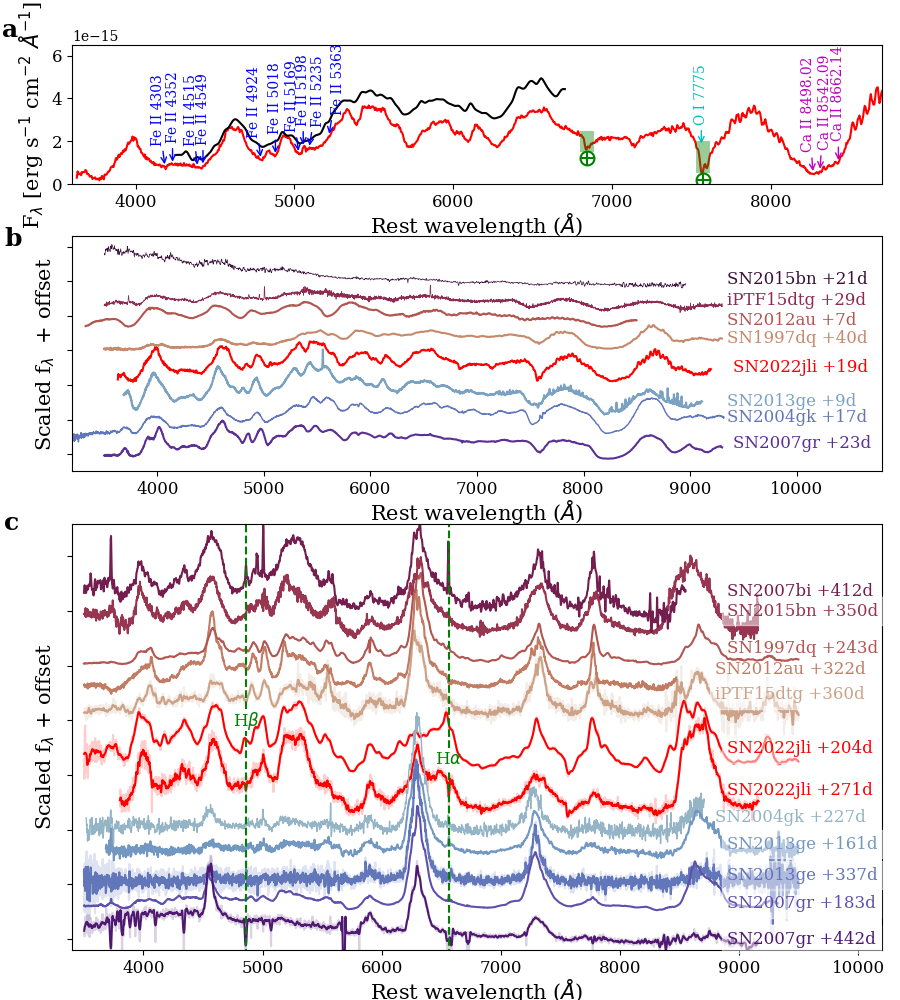

2.909288189492597e-13
not1125
2.893374629032918e-13
1.0054999999999992
5.0934082615899707e-14
5.711869224055537
9.870482824971485e-15
29.47462896275291
68.61621779144106
4.239942513787886e-15
2.5814292947133956e-13
1.1270067305157787
3.0468075982170777e-15
95.48644263572947
1.6029774595602536e-15
181.49276972932014
16.610907620393498
1.75143240572888e-14
83.00852835050526
3.504806370266036e-15
23.775306503606632
1.223659593642365e-14
722.1396307181193
4.028705898053961e-16
7.914466601712244
3.6759118913499376e-14


In [118]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'serif'

jd = Time('2022-05-24T10:00:31', format='isot').jd 
phase = jd-t0_22jli

specdata = np.loadtxt('../data/spectra/tns/tns_2022jzy_2022-05-24_10-00-31_ESO-NTT_EFOSC2-NTT_ePESSTO+.asci')

spec_interp = interp1d(specdata[:,0]/(1+z_22jli), specdata[:,1])

fig = plt.figure(figsize=(9,10))
gs0 = GridSpec(10, 1, figure=fig, hspace=1.2, wspace=0., left=0.08, right=0.98, bottom=0.05, top=0.955)

ax1 = fig.add_subplot(gs0[0:2, 0])

ax1.plot(specdata[:,0]/(1+z_22jli), specdata[:,1], 'r', label='SN2022jli efosc0524')
ax1.set_xlim([3600, 8700])
ax1.set_ylim([-1e-17, 6.5e-15])

spec0 = np.loadtxt('../data/spectra/tns/tns_2022jli_2022-05-11_03-27-00_Other_Other_PSH.dat')

ax1.plot(spec0[:,0]/(1+z_22jli), spec0[:,1]*2e-15, 'k', label='SN2022jli other0511')


ax1.set_xlabel(r'Rest wavelength ($\AA$)', fontsize=15, labelpad=0)
ax1.set_ylabel(r'F$_\lambda$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]', fontsize=15)


FeII_lines = [4303, 4352, 4515, 4549, 4924, 5018, 5169, 5198, 5235, 5363]
vshift_FeII = -8200.
for i, w in enumerate(FeII_lines):

    w_shifted = w*(1+vshift_FeII/300000)
    f = spec_interp(w_shifted)
    if i in [0, 2, 4, 6]:
        wadd = -45
    elif i in [8, 9]:
        wadd = 60
#    elif i ==9:
#        wadd = 30
    else:
        wadd = 0
    ax1.annotate("Fe II %s"%(str(w)),color='b', xy=(w_shifted, f), ha='center', va='bottom', xycoords='data',
            xytext=(w_shifted+wadd, f+1e-15), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='b'), rotation=90, fontsize=10)

CaII_lines = [8498.02, 8542.09, 8662.14]
vshift_CaII = -8200.
for i,w in enumerate(CaII_lines):
    w_shifted = w*(1+vshift_CaII/300000)
    f = spec_interp(w_shifted)
    if i==0:
        wadd = -30
    elif i ==1:
        wadd = 30
    else:
        wadd = 0
    ax1.annotate("Ca II %s"%(str(w)),color='m', xy=(w_shifted, f), ha='center', va='bottom', xycoords='data',
            xytext=(w_shifted+wadd, f+1e-15), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='m'), rotation=90, fontsize=10)    

w = 7775
vshift_OI = -8200
w_shifted = w*(1+vshift_OI/300000)
f = spec_interp(w_shifted) + 1.2e-15
wadd=0
ax1.annotate("O I %s"%(str(w)),color='c', xy=(w_shifted, f), ha='center', va='bottom', xycoords='data',
            xytext=(w_shifted+wadd, f+1e-15), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='c'), rotation=90, fontsize=10)     
    
    
    
ax1.vlines(np.array([6880])/(1+z_22jli), ymin=1.5e-15, ymax=2.5e-15, color='g', linestyles='solid', lw=10, alpha=0.4)
ax1.vlines(np.array([7614])/(1+z_22jli), ymin=5e-16, ymax=2e-15, color='g', linestyles='solid', lw=10, alpha=0.4)
ax1.plot(6880/(1+z_22jli), 1.2e-15, 'o', ms=10, mfc='none', mec='g', mew=1.5)
ax1.plot(6880/(1+z_22jli), 1.2e-15, '+', ms=10, mfc='none', mec='g', mew=1.5)

ax1.plot(7614/(1+z_22jli), 2e-16, 'o', ms=10, mfc='none', mec='g', mew=1.5)
ax1.plot(7614/(1+z_22jli), 2e-16, '+', ms=10, mfc='none', mec='g', mew=1.5)


ax1.tick_params(labelsize=12)



##---------------------------------

ax2 = fig.add_subplot(gs0[2:5, 0])

#####


specname = 'efosc0524'  #
spec = specs_22jli[specname]['spec']
phase = specs_22jli[specname]['phase']
xs = spec[:,0]/(1+z_22jli)
ys = spec[:,1]*0.3

xs_new, ys_new = spectrum_extinction_effect(xs, ys, -EBV, extmodel='gal3', compare_display=False)
ax2.plot(xs_new, ys_new*0.5, 'r', label='SN2022jli %sd')
ax2.text(9400, np.mean(ys_new[-10:])-3e-16, 'SN2022jli +{:.0f}d'.format(phase), color='r', va='center', fontsize=12)


cmap = mpl.cm.twilight_shifted
norm = mpl.colors.Normalize(vmin=0, vmax=1)


specname = '9.3d'
phase = 9.3
spec = specinfo_13ge[specname]['spec']
xs = spec[:,0]/(1+z_13ge)
offset = -1e-15
ys = spec[:,1]*3e-16 +offset
color = cmap((offset+3e-15)/6e-15)
ax2.plot(xs, ys, color=color, label='SN2013ge 9.3d')
ax2.text(9350, np.mean(ys[-10:]), 'SN2013ge +{:.0f}d'.format(phase), color=color, va='center', fontsize=12)




specname = '17.2d'
phase = 17
spec = specinfo_04gk[specname]['spec']
xs = spec[:,0]/(1+z_04gk)
offset = - 1.5e-15
ys = spec[:,1]*3e-16 +offset
color = cmap((offset+3e-15)/6e-15)
ax2.plot(xs, ys, color=color, lw=1, label='SN 2004gk')
ax2.text(9350, np.mean(ys[-10:]), 'SN2004gk +{:.0f}d'.format(phase), color=color, va='center', fontsize=12)




specname = '23.3d'
phase = 23.3
spec = specinfo_2007gr[specname]['spec']
xs = spec[:,0]/(1+z_07gr)
offset = - 2.2e-15
ys = spec[:,1]*5e-17 + offset
mask = (xs>3500)*(xs<9300)
ys = ys[mask]
xs = xs[mask]
color = cmap((offset+3e-15)/6e-15)
ax2.plot(xs, ys, color=color, label='2007gr '+specname)
ax2.text(9400, np.mean(ys[-10:])+1e-16, 'SN2007gr +{:.0f}d'.format(phase), color=color, va='center', fontsize=12)


    
specname = '39.6d'
phase = 39.6
spec = specinfo_97dq[specname]['spec']
xs = spec[:,0]/(1+z_97dq)
offset = 1e-15
ys = spec[:,1]*1e-16 + offset
mask = (xs>3500)*(xs<9300)
ys = ys[mask]
xs = xs[mask]
color = cmap((offset+3e-15)/6e-15)
ax2.plot(xs, ys, color=color, label='SN1997dq 39.6d')
ax2.text(9350, np.mean(ys[-10:]), 'SN1997dq +{:.0f}d'.format(phase), color=color, va='center', fontsize=12)


    
specname = '6.6d'
phase = 6.6
spec = specinfo_12au[specname]['spec']
xs = spec[:,0]/(1+z_12au)
offset = 1.5e-15
ys = spec[:,1]*6e-17 + offset
color = cmap((offset+3e-15)/6e-15)
ax2.plot(xs, ys, color=color, label='SN2012au 6.6d')    
ax2.text(9350, np.mean(ys[-10:]), 'SN2012au +{:.0f}d'.format(phase), color=color, va='center', fontsize=12)

    

specname = '29.1d'
phase = 29
spec = specinfo_15dtg[specname]['spec']
xs = spec[:,0]/(1+z_15dtg)
offset = 2e-15
ys = spec[:,1]*12 + offset
mask = (xs>3500)*(xs<9300)
ys = ys[mask]
xs = xs[mask]
color = cmap((offset+3e-15)/6e-15)
ax2.plot(xs, ys, color=color, lw=0.5, label='iPTF15dtg')
ax2.text(9350, np.mean(ys[-10:])+1.6e-16, 'iPTF15dtg +{:.0f}d'.format(phase), color=color, va='center', fontsize=12)



specname = '21.0d'
phase = 21
spec = specinfo_15bn[specname]['spec']
xs = spec[:,0]/(1+z_15bn)
offset = 2.8e-15
ys = spec[:,1] + offset
mask = (xs>3500)*(xs<9300)
ys = ys[mask]
xs = xs[mask]
color = cmap((offset+3e-15)/6e-15)
ax2.plot(xs, ys, color=color, lw=0.5, label='SN2015bn')
ax2.text(9350, np.mean(ys[-10:])+1.6e-16, 'SN2015bn +{:.0f}d'.format(phase), color=color, va='center', fontsize=12)


    
    
marklines = 0
if marklines:
    ax2.vlines([6300,6363], ymin = -9.5e-15, ymax=7.5e-15, linestyles='dashed', colors='k')
    ax2.vlines([4102,4340,4861,6563], ymin = -9.5e-15, ymax=7.5e-15, linestyles='dashed', colors='g')

ax2.set_yticklabels([])

ax2.set_xlim([3200,10800])

#ax.set_yticks([])
ax2.tick_params(labelsize=12)
ax2.set_xlabel('Rest wavelength ($\AA$)', fontsize=15, labelpad=0)
ax2.set_ylabel('Scaled f$_\lambda$  + offset', fontsize=15) #[erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]
ax2.set_ylim([-2.5e-15, 4.3e-15])


#######################################################################################
#### ax3

#This panel focuses on the late-time comparison 


ax3 = fig.add_subplot(gs0[5:10, 0])


xref1 = 6150 #in rest frame
xref2 = 6500
specname = 'not1125'  #
spec = specs_22jli[specname]['spec_photcal']
mask = (spec[:,0]>(xref1*(1+z_22jli)))*(spec[:,0]<(xref2*(1+z_22jli)))
xsref = spec[mask,0]
ysref = spec[mask,1]
refflux = trapz(ysref, xsref)
print(refflux)


showthis = 1
if showthis:
    specname = 'not1125'  #
    print(specname)
    spec = specs_22jli[specname]['spec_photcal']
    phase = specs_22jli[specname]['phase']
    xs = spec[:,0]/(1+z_22jli)
    ys = spec[:,1]
    mask = (xs>xref1)*(xs<xref2)
    intflux = trapz(ys[mask], xs[mask])
    print(intflux)
    scalefactor = refflux/intflux
    print(scalefactor)
    mask = (xs>3500)*(xs<9500)
    ys = ys[mask]*scalefactor - 1e-16
    xs = xs[mask]
    ys_smooth = savgol_filter(ys, 15, 2)
    ax3.plot(xs, ys, 'r', alpha=0.2, label='SN2022jli %sd')    
    ax3.plot(xs, ys_smooth, 'r', label='SN2022jli %sd')
    texth = ax3.text(8900, np.mean(ys[-10:])+2e-16, 'SN2022jli +{:.0f}d'.format(phase), color='r', va='center', fontsize=12)
    texth.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

    
    
    
    
showthis=1
if showthis:
    specname = 'binospec0131'  #
    spec = specs_22jli[specname]['spec']
    phase = specs_22jli[specname]['phase']
    xs = spec[:,0]/(1+z_22jli)
    ys = spec[:,1]
    mask = (xs>xref1)*(xs<xref2)
    intflux = trapz(ys[mask], xs[mask])
    print(intflux)
    scalefactor = refflux/intflux
    print(scalefactor)
    mask = (xs>3500)*(xs<9500)
    xs = xs[mask]
    ys = ys[mask]*scalefactor - 8e-16
    ys_smooth = savgol_filter(ys, 15, 2)
    ax3.plot(xs, ys, 'r', alpha=0.2, )
    ax3.plot(xs, ys_smooth, 'r', label='SN2022jli %sd')
    ax3.text(8900, np.mean(ys[-10:])+2e-16, 'SN2022jli +{:.0f}d'.format(phase), color='r', va='center', fontsize=12)


cmap = mpl.cm.twilight_shifted
#cmap = mpl.cm.twilight
norm = mpl.colors.Normalize(vmin=0, vmax=1)
        
        
specname = '359.6d'
spec = specinfo_15dtg[specname]['spec']
xs = spec[:,0]/(1+z_15dtg)
ys = spec[:,1]
mask = (xs>xref1)*(xs<xref2)
intflux = trapz(ys[mask], xs[mask])
print(intflux)
scalefactor = refflux/intflux
print(scalefactor)
mask = (xs>3500)*(xs<9500)
xs = xs[mask]
offset = 1e-15
ys = ys[mask]*scalefactor + offset
ys_smooth = savgol_filter(ys, 15, 2)
color = cmap((offset+4e-15)/8e-15)
ax3.plot(xs, ys, color=color, alpha=0.2, label='iPTF15dtg 359.6d')
ax3.plot(xs, ys_smooth, color=color, label='iPTF15dtg 359.6d')
texth = ax3.text(8800, np.mean(ys[-100:])+3e-16, 'iPTF15dtg +360d', color=color, va='center', fontsize=12)
texth.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))



specname = '321.6d'
spec = specinfo_12au[specname]['spec']
xs = spec[:,0]/(1+z_12au)
ys = spec[:,1]
mask = (xs>xref1)*(xs<xref2)
intflux = trapz(ys[mask], xs[mask])
print(intflux)
scalefactor = refflux/intflux
print(scalefactor)
mask = (xs>3500)*(xs<9500)
xs = xs[mask]
offset = 1.5e-15
ys = ys[mask]*scalefactor + offset
color = cmap((offset+4e-15)/8e-15)
ax3.plot(xs, ys, color=color, label='SN2012au 321.6d')
ax3.text(8800, np.mean(ys[-100:])+3e-16, 'SN2012au +322d', color=color, va='center', fontsize=12)


    
    
specname = '242.6d'
spec = specinfo_97dq[specname]['spec']
xs = spec[:,0]/(1+z_97dq)
ys = spec[:,1]
mask = (xs>xref1)*(xs<xref2)
intflux = trapz(ys[mask], xs[mask])
print(intflux)
scalefactor = refflux/intflux
print(scalefactor)
mask = (xs>3500)*(xs<9500)
xs = xs[mask]
offset = 2e-15
ys = ys[mask]*scalefactor + offset
color = cmap((offset+4e-15)/8e-15)
ax3.plot(xs, ys, color=color, label='SN1997dq 242.6d')
texth = ax3.text(8900, np.mean(ys[-100:])+2e-16, 'SN1997dq +243d', color=color, va='center', fontsize=12)
#texth.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='white'))

    

specname = '350.0d'
spec = specinfo_15bn[specname]['spec']
xs = spec[:,0]/(1+z_15bn)
ys = spec[:,1]
mask = (xs>xref1)*(xs<xref2)
intflux = trapz(ys[mask], xs[mask])
print(intflux)
scalefactor = refflux/intflux
print(scalefactor)
mask = (xs>3500)*(xs<9500)
xs = xs[mask]
offset = 2.5e-15
ys = ys[mask]*scalefactor + offset
color = cmap((offset+4e-15)/8e-15)
ax3.plot(xs, ys, color=color, label='SN2015bn 350.0d')
texth = ax3.text(8900, np.mean(ys[-100:])+3e-16, 'SN2015bn +350d', color=color, va='center', fontsize=12)
texth.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

    

specname = '412.0d'
spec = specinfo_07bi[specname]['spec']
xs = spec[:,0]/(1+z_07bi)
ys = spec[:,1]
mask = (xs>xref1)*(xs<xref2)
intflux = trapz(ys[mask], xs[mask])
print(intflux)
scalefactor = refflux/intflux
print(scalefactor)
mask = (xs>3500)*(xs<9500)
xs = xs[mask]
offset = 3e-15
ys = ys[mask]*scalefactor + offset
color = cmap((offset+4e-15)/8e-15)
ax3.plot(xs, ys, color=color, label='SN2007bi 412.0d')
ax3.text(8900, np.mean(ys[-100:])+3e-16, 'SN2007bi +412d', color=color, va='center', fontsize=12)

    
    
#---------
    
specname = '226.5d'
spec = specinfo_04gk[specname]['spec']
xs = spec[:,0]/(1+z_04gk)
ys = spec[:,1]
mask = (xs>xref1)*(xs<xref2)
intflux = trapz(ys[mask], xs[mask])
print(intflux)
scalefactor = refflux/intflux
print(scalefactor)
mask = (xs>3500)*(xs<9500)
xs = xs[mask]
offset = -1e-15
ys = ys[mask]*scalefactor + offset
color = cmap((offset+4e-15)/8e-15)
ax3.plot(xs, ys, color=color, lw=1, label='2004gk 226.5d')
ax3.text(8800, np.mean(ys[-100:]) - 1e-16, 'SN2004gk +227d', color=color, va='center', fontsize=12)



specname = '160.6d'
spec = specinfo_13ge[specname]['spec']
xs = spec[:,0]/(1+z_13ge)
ys = spec[:,1]
mask = (xs>xref1)*(xs<xref2)
intflux = trapz(ys[mask], xs[mask])
print(intflux)
scalefactor = refflux/intflux
print(scalefactor)
mask = (xs>3500)*(xs<9500)
xs = xs[mask]
offset =  -1.5e-15
ys = ys[mask]*scalefactor +offset
color = cmap((offset+4e-15)/8e-15)
ax3.plot(xs, ys, color=color, label='SN2013ge 160.6d')
texth = ax3.text(8900, np.mean(ys[-100:])+1e-16, 'SN2013ge +161d', color=color, va='center', fontsize=12)
texth.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

    
    
specname = '337.3d'
spec = specinfo_13ge[specname]['spec']
xs = spec[:,0]/(1+z_13ge)
ys = spec[:,1]
mask = (xs>xref1)*(xs<xref2)
intflux = trapz(ys[mask], xs[mask])
print(intflux)
scalefactor = refflux/intflux
print(scalefactor)
mask = (xs>3500)*(xs<9500)
xs = xs[mask]
offset = -2e-15
ys = ys[mask]*scalefactor + offset
color = cmap((offset+4e-15)/8e-15)
ys_smooth = savgol_filter(ys, 15, 2)
ax3.plot(xs, ys, color=color, alpha=0.2, label='SN2013ge 337.3d')
ax3.plot(xs, ys_smooth, color=color, label='SN2013ge 337.3d')
texth = ax3.text(8900, np.mean(ys[-100:])+1e-16, 'SN2013ge +337d', color=color, va='center', fontsize=12)
texth.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
 
    
    
specname = '183.0d'
spec = specinfo_2007gr[specname]['spec']
xs = spec[:,0]/(1+z_07gr)
ys = spec[:,1]
mask = (xs>xref1)*(xs<xref2)
intflux = trapz(ys[mask], xs[mask])
print(intflux)
scalefactor = refflux/intflux
print(scalefactor)
mask = (xs>3500)*(xs<9500)
xs = xs[mask]
offset = -2.5e-15
ys = ys[mask]*scalefactor +offset
color = cmap((offset+4e-15)/8e-15)
ax3.plot(xs, ys, color=color, label='2007gr 183.0')
texth = ax3.text(8900, np.mean(ys[-100:]), 'SN2007gr +183d', color=color, va='center', fontsize=12)
texth.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))


specname = '441.5d'
spec = specinfo_2007gr[specname]['spec']
xs = spec[:,0]/(1+z_07gr)
ys = spec[:,1]
mask = (xs>xref1)*(xs<xref2)
intflux = trapz(ys[mask], xs[mask])
print(intflux)
scalefactor = refflux/intflux
print(scalefactor)
mask = (xs>3500)*(xs<9500)
xs = xs[mask]
offset = -3.3e-15
ys = ys[mask]*scalefactor + offset
ys_smooth = savgol_filter(ys, 15, 2)
color = cmap((offset+4e-15)/8e-15)
ax3.plot(xs, ys, color=color, alpha=0.2, label='2007gr 381.6d')
ax3.plot(xs, ys_smooth, color=color, label='2007gr 381.6d')
texth = ax3.text(8900, np.mean(ys[-100:])+1e-16, 'SN2007gr +442d', color=color, va='center', fontsize=12)
texth.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))


    
#ax3.legend(loc=0)

#ax3.plot(spec_18ibb[:,0]/(1+z_18ibb), spec_18ibb[:,1]*100-5.5e-15)

marklines = 1
if marklines:
    ax3.vlines([4861], ymin = -9.5e-15, ymax=8e-16, linestyles='dashed', colors='g')
    ax3.vlines([4861], ymin = 1.2e-15, ymax=7.5e-15, linestyles='dashed', colors='g')
    ax3.text(4861, 9e-16, r'H$\beta$', fontsize=12, color='g', ha='center')

    ax3.vlines([6563], ymin = -9.5e-15, ymax=1e-16, linestyles='dashed', colors='g')
    ax3.vlines([6563], ymin = 5e-16, ymax=7.5e-15, linestyles='dashed', colors='g')

    ax3.text(6563, 2e-16, r'H$\alpha$', fontsize=12, color='g', ha='center')
    

ax3.set_yticklabels([])

ax3.set_xlim([3400,10200])
ax3.set_ylim([-3.2e-15, 4.6e-15])

#ax3.set_yticks([])
ax3.tick_params(labelsize=12)
ax3.set_xlabel('Rest wavelength ($\AA$)', fontsize=15, labelpad=0)
ax3.set_ylabel('Scaled f$_\lambda$ + offset', fontsize=15)





ax1.set_title('a', fontsize=18, loc='left', pad=20, x=-0.087, y=0.86, fontweight='bold')
ax2.set_title('b', fontsize=18, loc='left',  pad=20, x=-0.084, y=0.84, fontweight='bold')
ax3.set_title('c', fontsize=18, loc='left',  pad=20, x=-0.084, y=0.92, fontweight='bold')


plt.savefig('../plots/sn2022jli_spectra_evolution_comparison.pdf')